# Телеком: прогнозирование оттока клиентов

<h1> I часть: ПЛАН </h1>

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.\
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.\
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Задача проекта

Построить модель, которая на основе предоставленных данных сделает прогноз: уйдёт клиент от оператора в ближайшее время или нет (задача классификации).

Качество предсказания оцениваем метрикой ROC-AUC >= 0.85 (целевой показатель)

## 1. Загрузка и подготовка данных

### 1.1 Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# !pip install phik

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix

# импорт моделей 
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# предварительная обработка
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split,
    cross_val_predict
)

# метрики
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, auc

# настройки
import warnings
warnings.filterwarnings("ignore")
from skimpy import clean_columns

# константа верхний регистр
RANDOM_STATE = 50623

### Описание данных

- `BeginDate` – дата начала пользования услугами
- `EndDate` – дата окончания пользования услугами
- `Type` – тип оплаты: ежемесячный, годовой и т.д.
- `PaperlessBilling` – безналичный расчет
- `PaymentMethod` – способ оплаты
- `MonthlyCharges` – ежемесячные траты на услуги
- `TotalCharges` – всего потрачено денег на услуги
- `Dependents` – наличие иждивенцев
- `Senior Citizen` – наличие пенсионного статуса по возрасту
- `Partner` – наличие супруга(и)
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [3]:
# загрузим данные
df_contract = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\contract_new.csv')
df_personal = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\personal_new.csv')
df_internet = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\internet_new.csv')
df_phone = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\phone_new.csv')

In [4]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head(5))
    display(data.tail(5))
    data.info()
    display(data.describe())
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

### 1.2. Общая информация contract_new

In [5]:
get_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000



Размер таблицы: (7043, 8)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


### 1.3. Общая информация personal_new

In [6]:
get_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000



Размер таблицы: (7043, 5)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


### 1.4. Общая информация internet_new

In [7]:
get_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Размер таблицы: (5517, 8)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


### 1.5. Общая информация phone_new

In [8]:
get_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390



Размер таблицы: (6361, 2)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


## Выводы

1. Пропуски и явные дубликаты в таблицах не обнаружены.
2. Приведем названия столбцов к единому стилю - snake_case.
3. Потребуется изменить типы данных для большинства признаков.
4. Для дальнейшей работы объединим таблицы по customerID, появятся пропуски.
5. Целевой признак EndDate.
6. Добавим признак lifetime_value (продолжительность жизни клиента) - это период с момента подключения и до прекращения контракта.
7. Для тех клиентов, кто ещё сотрудничает с провайдером, конечным сроком будет дата актуальной информации о договорах - 1 февраля 2020
 

### Примерный план работы

**1. Проведем предобработку данных:**

* объединим таблицы по ключу `customerID`
* изучим пропуски и решим, что с ними делать
* приведем данные к соответствующим типам
* сформируем дополнительный(е) признак(и)


**2. Проведем исследовательский анализ данных**

* исследуем числовые признаки на предмет выбросов и аномальных значений
* исследуем категориальные признаки (посмотрим уникальные значения, пропуски, оценим баланс)
* сравним различные признаки в группах клиентов
* построим графики

**3. Подготовим обучающие и целевой признаки:**

* разделим на выборки - train = 0.75, test = 0.25 (используем кросс-валидацию)
* кодируем категориальные признаки
* масштабируем численные признаки

**4. Соберем PipeLine моделей**

* протестируем модели и подберем для них гиперпараметры с помощью кросс-валидации
* добьемся лучшего показателя для метрики ROC-AUC>=0.85
* лучшую модель протестируем на выборке test

**5. Сделаем и опишем выводы**

**6. Подготовим отчет о работе**

<h1> II часть: КОД </h1>

## 2. Предобработка данных

### 2.1 Объединим таблицы по ключу customerID

Объединение таблиц df_contract, df_personal, df_internet и df_phone по столбцу customerID\
Вывод объединенной таблицы

In [9]:
df = pd.merge(df_contract, df_personal, on='customerID', how='outer')
df = pd.merge(df, df_internet, on='customerID', how='outer')
df = pd.merge(df, df_phone, on='customerID', how='outer')

df.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


### 2.2 Приведем названия столбцов к единому стилю - snake_case

С помощью функции clean_columms из Skimpy переведем названия столбцов в snake стиль 

In [10]:
df = clean_columns(df)
df.columns.tolist()

19 column names have been cleaned

['customer_id',
 'begin_date',
 'end_date',
 'type',
 'paperless_billing',
 'payment_method',
 'monthly_charges',
 'total_charges',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines']

Оцемим результат и получим общую информацию о таблице

In [11]:
get_info(df)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

,monthly_charges,senior_citizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000



Размер таблицы: (7043, 20)

Количество явных дубликатов: 0

Количество пропусков в таблице: 11364


### 2.3 Оценим количество пропусков в столбцах

In [12]:
# функция для подсчета пропусков в столбцах в процентах
def lost(data):
    if data.isna().sum().sum()>0:
        display(
            (round(data.isna().mean()*100,3))
            .to_frame()
            .rename(columns = {0:'Пропуски'})
            .query('Пропуски > 0')
            .sort_values(by = 'Пропуски', ascending = False)
            .style.background_gradient('coolwarm')
        )
    else:
        print('Пропусков нет')

In [13]:
lost(df)

,Пропуски
internet_service,21.667000
online_security,21.667000
online_backup,21.667000
device_protection,21.667000
tech_support,21.667000
streaming_tv,21.667000
streaming_movies,21.667000
multiple_lines,9.683000


Пропуски означают, что клиент не пользовался услугой и поэтому его нет в соответсвующей таблице.\
Поэтому заменим все пропуски на значение 'Nо'

Можно сделать промежуточный вывод о клиентах:
* более 21% клиентов не пользуются Интернет-сервисами
* почти 10% клиентов не пользуются несколькми линиями

Заменим пропусков в таблице значением 'Nо' и проверим результат

In [14]:
df = df.fillna('No')
lost(df)

Пропусков нет


### 2.4 Приведем данные к соответствующим типам

Столбец `total_charges` переведем в числовой вид

In [15]:
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

Столбец `end_date` содержит дату ухода клиента, если значение "No", то клиент продолжает пользоваться услугами.\
Создадим отдельный столбец для целевого признака `exited`, в котором укажем клиент ушел - 1, пользуется услугами оператора - 0.

In [16]:
df['exited'] = (df['end_date'] != 'No').astype(int)

Теперь значения "No" в столбце `end_date` можем заменить датой на которую информация о договорах актуальна -  1 февраля 2020.\
А затем преведем столбцы `begin_date` и `end_date` в формат дат.
- заменим значения в столбце `end_date`
- переведем столбцы `begin_date` и `end_date` в формат даты
- проверим результат

In [17]:
df['end_date'] = df['end_date'].replace('No', '2020-02-01')

df['begin_date'] = pd.to_datetime(df['begin_date'])
df['end_date'] = pd.to_datetime(df['end_date'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   7043 non-null   object        
 13  online_security    7043 non-null   object        
 14  online_b

В столбце `total_charges` появились пропуски.
Проверим.

In [18]:
lost(df)

,Пропуски
total_charges,0.156000


Пропусков немного, менее 1%, допустимо удалить.\
Но данных у нас немного, поэтому посмотрим, с чем они связаны и попробуем заполнить.\
Изучим строки с пропусками.

In [19]:
missings = df[df['total_charges'].isnull()]
missings

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,...,Yes,No,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,...,Yes,No,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


У клиентов с пропусками в столбце `total_charges` совпадают даты подключения `begin_date` и даты выгрузки `end_date`, а значения в `exited` говорят, что клиенты продолжают пользоваться услугами. Вероятно, это клиенты подключенные в день выгрузки базы. 

Столбец `total_charges` содержит информацию о том, сколько всего потрачено денег на услуги.\
Столбец `monthly_charges` содержит информацию о ежемесячных тратах на услуги.\
Похоже, что для клиентов, которые только заключили контракт верно, что - "всего потрачено" = "ежемесячные траты".\
Руководствуясь этим предположением заполним пропуски в `total_charges` значениями из `monthly_charges`.

Заполним пропуски в `total_charges` и проверим результат

In [20]:
df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'])
# проверка 
lost(df)

Пропусков нет


### 2.5 Cформируем дополнительный признак lifetime_value (срок пользования услугами)

Создадим новый столбец `lifetime_value` в который сохраним общий срок пользования услугами в днях.\
Считаем с даты начала договора и до даты отключения или актуальаной даты на момент выгрузки данных.

In [21]:
df['lifetime_value'] = (df['end_date'] - df['begin_date']).dt.days

### 2.6 Удалим признаки, которые не потребуются для обучения

Признаки на удаление:
* `customer_id` - уникальный номер клиента
* `begin_date` - дата подлючения клиента
* `end_date` - дата ухода (для дальнейшей работы важен сам факт, а не дата)

In [22]:
df = df.drop(['customer_id', 'begin_date', 'end_date' ], axis=1)

In [23]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,lifetime_value
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


In [24]:
df.tail()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited,lifetime_value
7038,One year,Yes,Mailed check,84.80,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,0,730
7039,One year,Yes,Credit card (automatic),103.20,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,0,2191
7040,Month-to-month,Yes,Electronic check,29.60,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No,0,337
7041,Month-to-month,Yes,Mailed check,74.40,520.80,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes,0,215
7042,Two year,Yes,Bank transfer (automatic),105.65,7251.82,Male,0,No,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No,0,2010


## 3. Исследовательский анализ

1. Выделим числовые признаки и сохраним их в отдельную таблицу numeric
2. Выделим категориальные признаки и сохраним их в отдельную таблицу categorical

In [25]:
numeric = df[df.select_dtypes(include='number').columns]
numeric.head(5)

,monthly_charges,total_charges,senior_citizen,exited,lifetime_value
0,29.85,31.04,0,0,31
1,56.95,2071.84,0,0,1036
2,53.85,226.17,0,0,123
3,42.30,1960.60,0,0,1371
4,70.70,353.50,0,0,153


In [26]:
categorical = df[df.select_dtypes(include='object').columns]
categorical.head(5)

,type,paperless_billing,payment_method,gender,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,Month-to-month,Yes,Electronic check,Female,Yes,No,DSL,No,Yes,No,No,No,No,No
1,One year,No,Mailed check,Male,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,Male,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),Male,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,Month-to-month,Yes,Electronic check,Female,No,No,Fiber optic,No,No,No,No,No,No,No


### Построим корреляционную матрицу для смешанного набора признаков

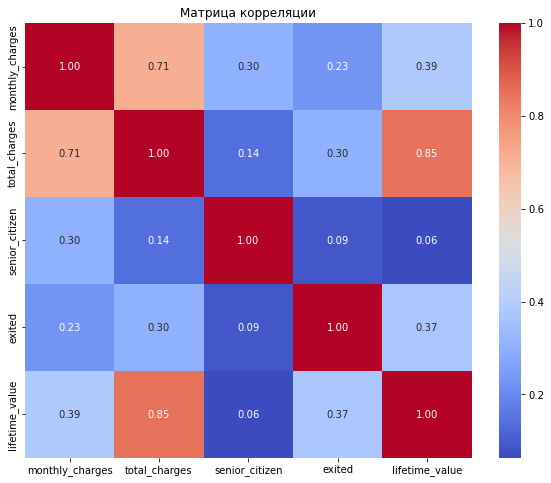

In [27]:
interval_cols = ['monthly_charges', 'total_charges', 'senior_citizen', 'exited', 'lifetime_value']
phik_matrix = numeric.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Матрица корреляции')
plt.show()

1. Зависимость между `total_charges` и `lifetime_value` - чем дольше срок пользования, тем больше потрачено на услуги и наоборот.
2. Зависимость между `total_charges` и `monthly_charges` - размер ежемесячных платежей влияет на общие расходы.
3. Больше всего факт ухода клиента `exited` коррелирует с расходами за месяц `lifetime_value` - умеренная положительная связь.
4. Целевой признак `exited` связан слабой положительной связью с `total_charges` и `monthly_charges`.

Признак`total_charges` имеет сильную положительную корреляционную связь с признакими `lifetime_value` и `monthly_charges` - мультиколлинеарность.\
С одной стороны, это может повлиять на результаты обучения модели.\
А с другой, алгоритмы классификации, которые я планирую использовать: DecisionTree, RandomForest и CatBoost считаются устойчивыми к мультиколлинеарности.

Поэтому на этом этапе ничего не предпринимаю, но если показатели метрики будет недостаточные, то вероятно, нужно будет удалить `total_charges`.

### Исследуем числовые признаки

**Исследуем выбивающиеся значения в столбцах**

In [29]:
(
    df[['monthly_charges', 'total_charges', 'lifetime_value']]
    .apply (['count', 'min', 'mean', 'median', 'max'])
    .style.format("{:,.2f}")
)

,monthly_charges,total_charges,lifetime_value
count,"7,043.00","7,043.00","7,043.00"
min,18.25,19.05,0.00
mean,64.76,"2,115.38",898.56
median,70.35,"1,343.35",761.00
max,118.75,"9,221.38","2,314.00"


### 3.1 Столбец "monthly_charges"

**1. Построим гистограмму для столбца `monthly_charges`**

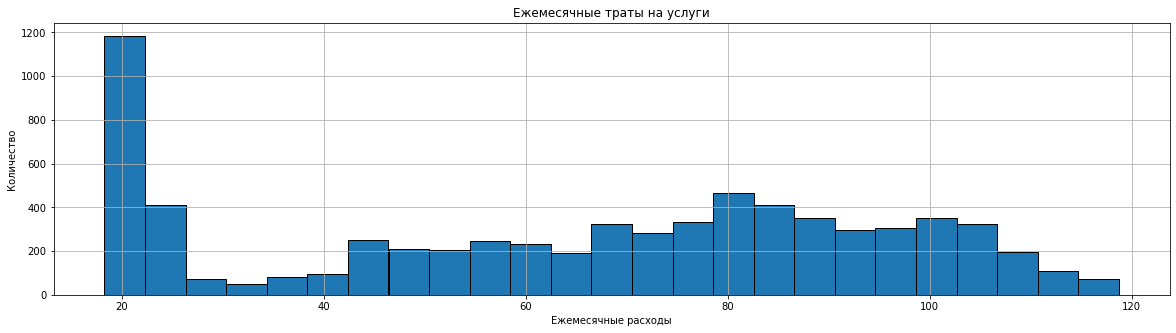

In [30]:
df.monthly_charges.hist(bins=25, edgecolor='black', linewidth=1, figsize=(20,5))
plt.xlabel('Ежемесячные расходы')
plt.ylabel('Количество')
plt.title('Ежемесячные траты на услуги')
plt.grid(True)
plt.show()

**2. Исследуем выбивающиеся значения признака`monthly_charges`**

In [31]:
df.monthly_charges.describe().to_frame().style.format("{:,.2f}")

,monthly_charges
count,"7,043.00"
mean,64.76
std,30.09
min,18.25
25%,35.50
50%,70.35
75%,89.85
max,118.75


**3. Построим боксплот для столбца `monthly_charges`**

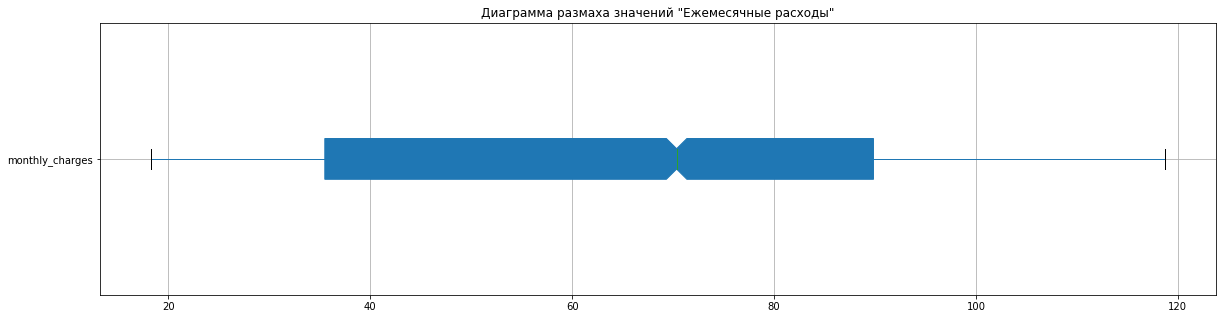

In [32]:
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['monthly_charges']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Ежемесячные расходы"');

#### Вывод

- На гистограмме распределение данных близко к нормальному, с выбивающимися значениями около 18-22 (вероятно новые клиенты)
- Боксплот в целом выглядит сбалансированным, без выбросов

In [33]:
# группируем месячные расходы на услуги в 10 групп
df['categories_monthly_charges'] = pd.qcut(df.monthly_charges, 10)
df['categories_monthly_charges_range'] = df['categories_monthly_charges'].apply(lambda x: f'от {x.left:.2f} до {x.right:.2f}')
# рассчитаем медианну для каждой категории общих расходов клиентов, посмотрим на их количество
med_categories_monthly_charges = df.groupby('categories_monthly_charges_range').monthly_charges.agg(['median', 'mean','count']).reset_index()
med_categories_monthly_charges

,categories_monthly_charges_range,median,mean,count
0,от 18.25 до 20.05,19.650,19.629637,717
1,от 20.05 до 25.05,20.650,21.813229,703
2,от 25.05 до 45.85,35.650,35.710144,695
3,от 45.85 до 58.83,53.150,52.551282,702
4,от 58.83 до 70.35,65.500,65.357454,711
5,от 70.35 до 79.10,74.775,74.673286,700
6,от 79.10 до 85.50,81.450,82.162979,705
7,от 85.50 до 94.25,89.850,89.865028,702
8,от 94.25 до 102.60,98.575,98.048224,704
9,от 102.60 до 118.75,107.425,108.268963,704


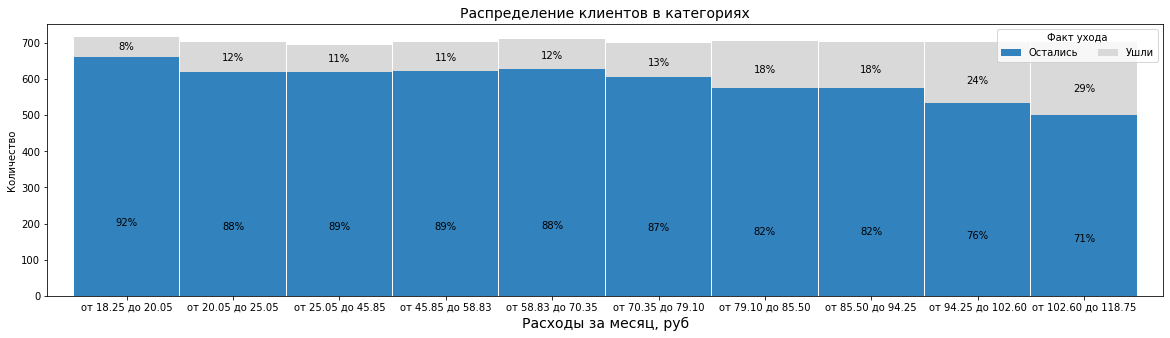

In [34]:
pivot_table_monthly = df.pivot_table(index='categories_monthly_charges_range', columns='exited', aggfunc='size')

# построим график
pivot_table_monthly.plot(kind='bar', width = 0.99, rot=0, stacked=True, figsize=(20, 5), colormap='tab20c')
plt.xlabel('Расходы за месяц, руб', fontsize=14)
plt.ylabel('Количество')
plt.title('Распределение клиентов в категориях', fontsize=14)
legend_labels = ['Остались', 'Ушли']  # Список значений в легенде
plt.legend(title='Факт ухода', labels=legend_labels, loc="best", ncol=8)
 
# подписи долей на графике
monthly_values = pivot_table_monthly.sum(axis=1)  # сумма значений по каждой категории
for n, x in enumerate(pivot_table_monthly.index.values):
    for (value, y_loc) in zip(pivot_table_monthly.loc[x], pivot_table_monthly.loc[x].cumsum()):
        if value > 0:  # печатаем значения только больше 0
            proportion = value / monthly_values[x]  # вычисляем процентное соотношение относительно суммы значений
            plt.text(x=n,  # положение по оси x
                     y=y_loc - value / 1.4,  # положение по оси y
                     color="black",  # цвет шрифта подписей
                     s=f'{proportion:.0%}',  # форматируем доли в процентах с двумя знаками после запятой
                     fontsize=10,  # размер шрифта подписей
                     ha='center',  # выравнивание текста по центру столбца
                     va='bottom'  # выравнивание текста внизу столбца
                     )
plt.show()

#### Вывод

1. На графике видна зависимость между ежемесячными расходами и вероятность ухода клиента

### 3.2 Столбец "total_charges"

**1. Построим гистограмму для столбца `total_charges`**

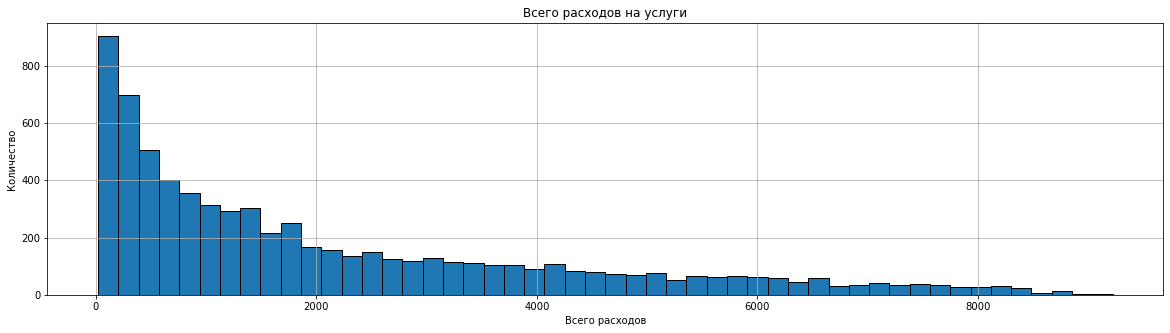

In [35]:
df.total_charges.hist(bins=50, edgecolor='black', linewidth=1, figsize=(20,5))
plt.xlabel('Всего расходов')
plt.ylabel('Количество')
plt.title('Всего расходов на услуги')
plt.grid(True)
plt.show()

**2. Исследуем выбивающиеся значения признака `total_charges`**

In [36]:
df.total_charges.describe().to_frame().style.format("{:,.2f}")

,total_charges
count,"7,043.00"
mean,"2,115.38"
std,"2,112.68"
min,19.05
25%,436.75
50%,"1,343.35"
75%,"3,236.69"
max,"9,221.38"


**3. Построим боксплот для столбца `total_charges`**

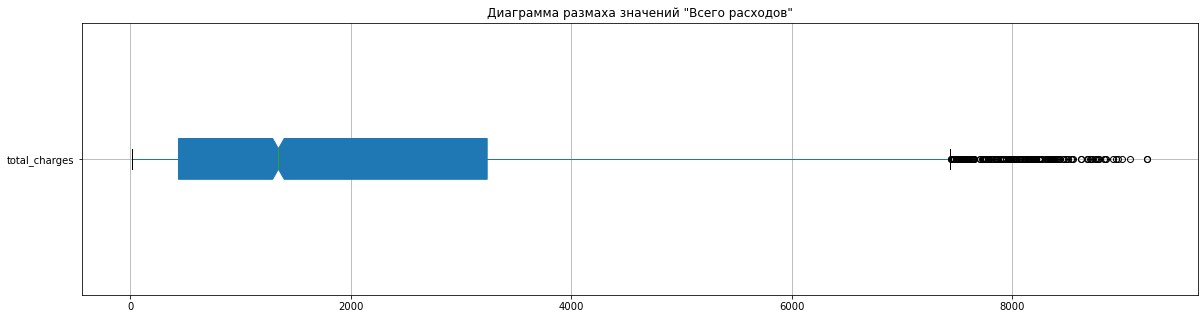

In [37]:
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['total_charges']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Всего расходов"');

**4. Посчитаем квантили и выведем верхнюю и нижнюю границы боксплота признака `total_charges`**

In [38]:
Q1 = df.total_charges.quantile(0.25)
Q3 = df.total_charges.quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR
lower = Q1 - 1.5 * IQR 

print('Верхняя граница:', upper)
print('Нижняя граница:', lower)

Верхняя граница: 7436.599999999999
Нижняя граница: -3763.16


**5. Оценим количество строк с общими расходами, которые выходят из диапозона 19 - 7500 по признаку `total_charges`**

In [39]:
df[['total_charges']].query(' total_charges < 19 or total_charges > 7500').count()

total_charges    181
dtype: int64

In [40]:
# группируем все общие расходы на услуги в 10 групп
df['categories_total_charges'] = pd.qcut(df.total_charges, 10)
df['categories_total_charges_range'] = df['categories_total_charges'].apply(lambda x: f'от {x.left:.2f} до {x.right:.2f}')
# рассчитаем медианну для каждой категории общих расходов клиентов, посмотрим на их количество
med_categories_total_charges = df.groupby('categories_total_charges_range').monthly_charges.agg(['median', 'mean','count']).reset_index()
med_categories_total_charges

,categories_total_charges_range,median,mean,count
0,от 19.05 до 152.41,24.100,34.636170,705
1,от 152.41 до 330.02,48.400,48.656676,704
2,от 330.02 до 572.40,50.675,51.558665,704
3,от 572.40 до 914.52,54.175,52.989063,704
4,от 914.52 до 1343.35,54.250,53.467021,705
5,от 1343.35 до 1850.76,60.875,60.485227,704
6,от 1850.76 до 2711.47,79.125,75.754190,704
7,от 2711.47 до 3844.87,84.250,81.904545,704
8,от 3844.87 до 5518.08,89.425,87.209872,704
9,от 5518.08 до 9221.38,104.000,100.962908,705


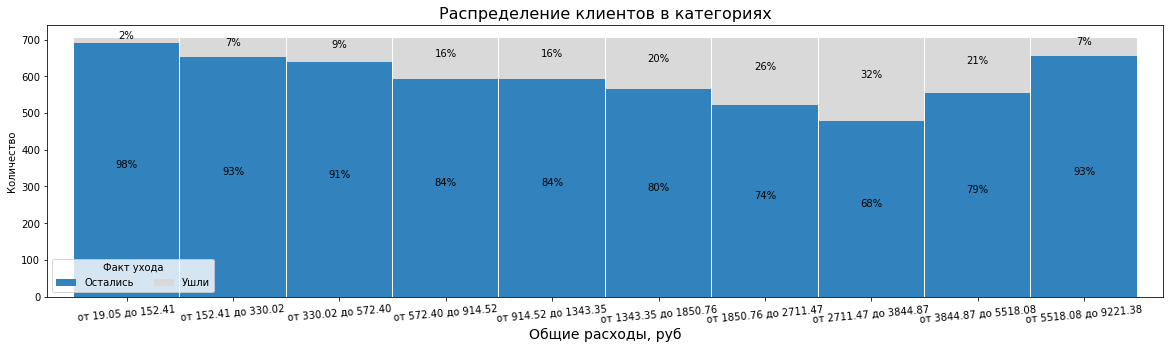

In [41]:
pivot_table_total = df.pivot_table(index='categories_total_charges_range', columns='exited', aggfunc='size')

# построим график
pivot_table_total.plot(kind='bar', width = 0.99, rot=5, stacked=True, figsize=(20, 5), colormap='tab20c')
plt.xlabel('Общие расходы, руб', fontsize=14)
plt.ylabel('Количество')
plt.title('Распределение клиентов в категориях', fontsize=16)
legend_labels = ['Остались', 'Ушли']  # Список значений в легенде
plt.legend(title='Факт ухода', labels=legend_labels, loc="best", ncol=8)
 
# подписи долей на графике
total_values = pivot_table_total.sum(axis=1)  # сумма значений по каждой категории
for n, x in enumerate(pivot_table_total.index.values):
    for (value, y_loc) in zip(pivot_table_total.loc[x], pivot_table_total.loc[x].cumsum()):
        if value > 0:  # печатаем значения только больше 0
            proportion = value / total_values[x]  # вычисляем процентное соотношение относительно суммы значений
            plt.text(x=n,  # положение по оси x
                     y=y_loc - value / 2,  # положение по оси y
                     color="black",  # цвет шрифта подписей
                     s=f'{proportion:.0%}',  # форматируем доли в процентах с двумя знаками после запятой
                     fontsize=10,  # размер шрифта подписей
                     ha='center',  # выравнивание текста по центру столбца
                     va='bottom'  # выравнивание текста внизу столбца
                     )
plt.show()

#### Вывод

1. На графике видно, что высокие общие расходы не сильно влияют на уход клиента, как средние.

#### Вывод

- На диаграмме ассиметричное распределение с хвостом вправо
- Боксплот с явными выбросами

Можно попробовать удалить строки значения которых выходят из диапазона значений 19 - 7500 - это 181 строка.\
Это позволить сбалансировать боксплот и, вероятно, приведет распределение к боллее нормальному виду. 

Но, терять даже 2,5% строк не хочется, тем более нет гарантий, что это даст нужный результат.\
А ещё выше определи, что признак `total_charges` является одним из двух мультиколлениарных и вероятно потребуется его удалить.\
Теперь так и поступим - удалим `total_charges`

In [42]:
df = df.drop(['total_charges'], axis=1)

### 3.3 Столбец "lifetime_value"

**1. Построим гистограмму для столбца `lifetime_value`**

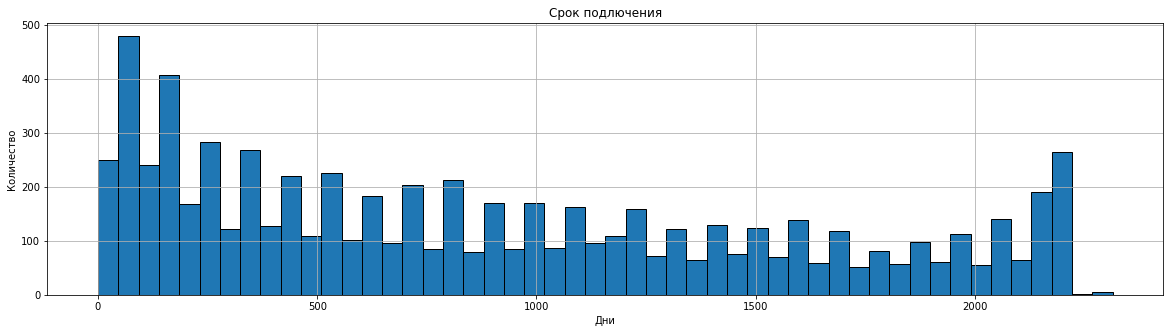

In [43]:
# построим гистограмму
df.lifetime_value.hist(bins=50, edgecolor='black', linewidth=1, figsize=(20,5))
plt.xlabel('Дни')
plt.ylabel('Количество')
plt.title('Срок подлючения')
plt.grid(True)
plt.show()

**2. Исследуем выбивающиеся значения признака `lifetime_value`**

In [44]:
df.lifetime_value.describe().to_frame().style.format("{:,.2f}")

,lifetime_value
count,"7,043.00"
mean,898.56
std,683.13
min,0.00
25%,276.00
50%,761.00
75%,"1,461.00"
max,"2,314.00"


**3. Построим боксплот для столбца `lifetime_value`**

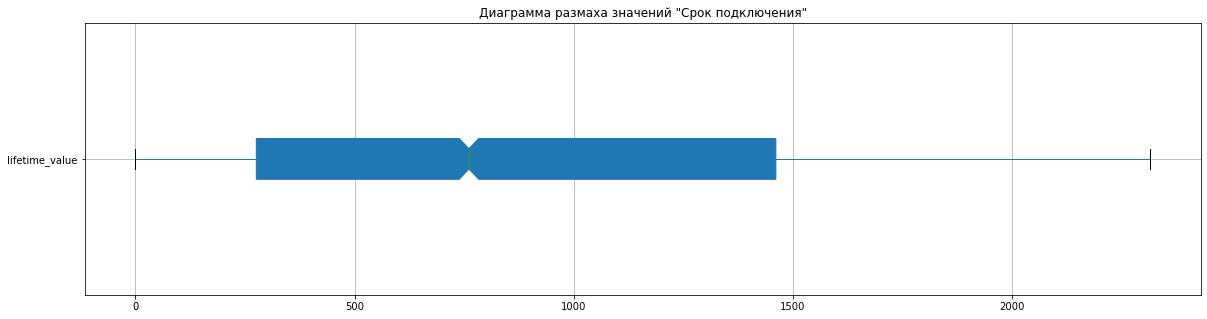

In [45]:
fig, ax = plt.subplots(figsize = (20,5))
ax = df[['lifetime_value']].boxplot(vert=False, ax=ax, patch_artist=True, notch=True)
ax.set_title('Диаграмма размаха значений "Срок подключения"');

#### Вывод

- На гистограмме мультимодальное распределение
- Боксплот в целом выглядит сбалансированным
- Явных выбросов и аномальных значений не выявлено

### 3.4 Оценим сбалансированность целевого признака "exited"

**Посчитаем количество уникальных значений в целевом признаке**

     exited
0  0.843675
1  0.156325


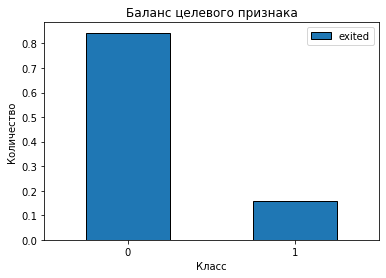

In [46]:
class_frequency = df['exited'].value_counts(normalize= True).to_frame()
print(class_frequency)

ax = class_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')
ax.set_title('Баланс целевого признака');
plt.show()

#### Вывод

- Целевой признак не сбалансирован
- Используем балансировку классов внутри модели

### 3.5 Изучим признак "senior_citizen"

**1. Посчитаем количество уникальных значений в признаке `senior_citizen`**

   senior_citizen
0        0.837853
1        0.162147


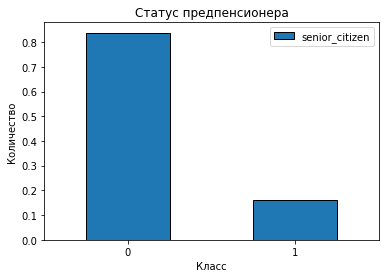

In [47]:
citizen_frequency = df['senior_citizen'].value_counts(normalize= True).to_frame()
print(citizen_frequency)

ax = citizen_frequency.plot(kind='bar', rot=0, edgecolor='black', linewidth=1)
ax.set_xlabel('Класс')
ax.set_ylabel('Количество')
ax.set_title('Статус предпенсионера');
plt.show()

**2. Оценим, как статус предпенсионера влияет на вероятность ухода клиента**

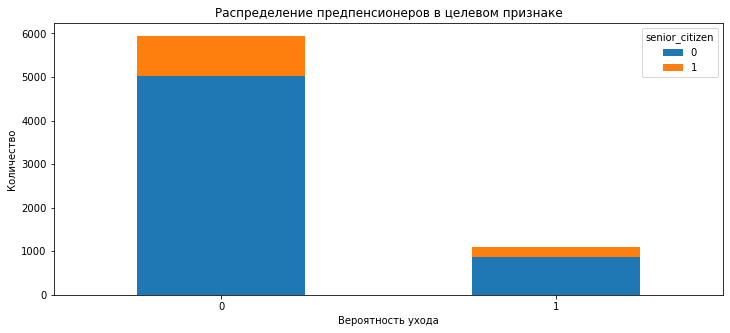

In [48]:
# создадим сводную таблицу
pivot_table = df.pivot_table(index='exited', columns='senior_citizen', aggfunc='size')

# построим график
pivot_table.plot(kind='bar', rot=0, stacked=True, figsize=(12, 5))
plt.xlabel('Вероятность ухода')
plt.ylabel('Количество')
plt.title(f'Распределение предпенсионеров в целевом признаке')
plt.legend(title='senior_citizen')

plt.show()

#### Вывод

- Клиентов в статусе предпенсионера всего 16%
- Основные клиенты оператора - люди трудоспособного возраста
- Среди ушедших клиентов предпенсионеры не преобладают

### Исследуем категориальные признаки

**Отобразим категориальные данные на круговых диаграммах**

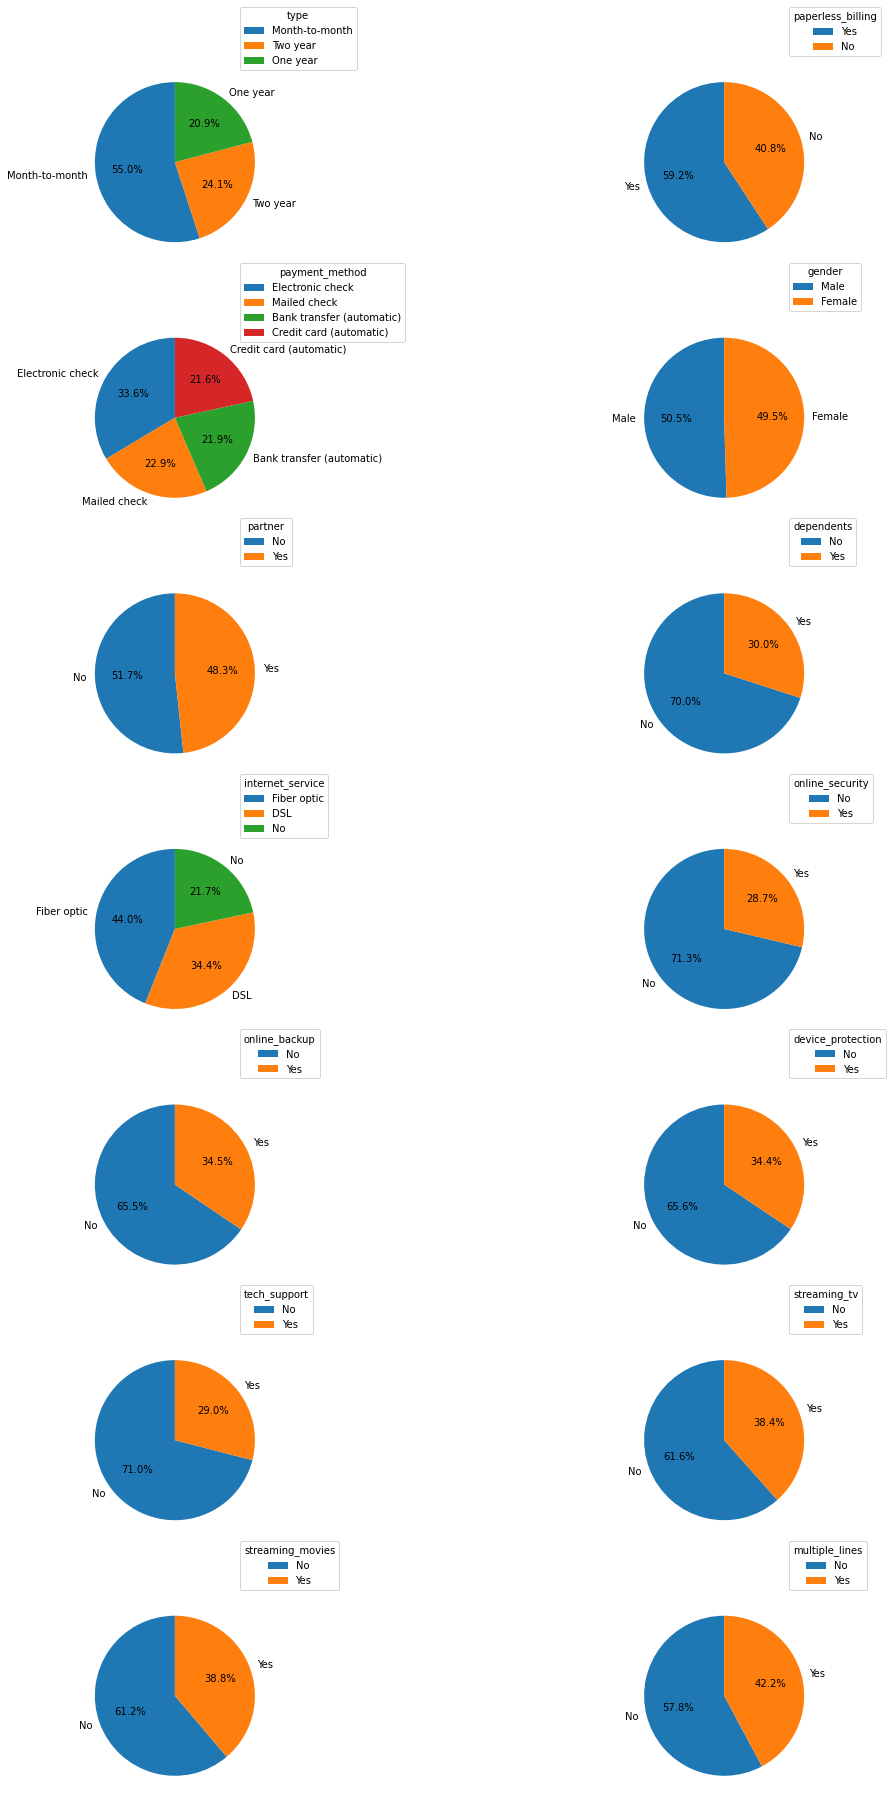

In [49]:
fig, axis = plt.subplots(7, 2, figsize=(17, 25))

n = 0
for i in range(7):
    for j in range(2):
        if n < len(categorical.columns):
            categorical[categorical.columns[n]].value_counts().plot.pie(ax=axis[i, j], autopct='%1.1f%%', startangle=90)
            axis[i, j].set_ylabel('')
            axis[i, j].legend(title=categorical.columns[n], loc='upper left', bbox_to_anchor=(0.8, 1.3))
            n += 1

plt.tight_layout()
plt.show()

#### Вывод

1. 55% клиентов предпочитают оплачивать услуги помесячно, поэтому будут чувствительны к изменениям цены среди года. Они в группе риска по уходу.
2. Клиентов, которые платят сразу за год (21%) или за два (24%), практически поровну. Риск их ухода в течении срока оплаченных услуг мал.
3. Почти 60% клиентов предпочитают безналичный расчет и среди способов оплаты преобладают электронные и дистанционные варианты оплаты.
4. Клиентов мужчин и женщин практически поровну, поэтому пол, вероятно, не будет относить клиента в группу риска по уходу. Тоже самое можно сказать и о наличии или отсутвии у клиента партнера.
5. У 70% клиентов отсутствуют иждивенцы, а значит они более платежеспособны.
6. Более 20% клиентов не используют дополнительные услуги оператора связанные с интернетом: антивирус, блокировку небезопасных сайтов, линию технической поддержки и другие.
7. Наличие возможности ведения параллельных линий во время звонка интересно только 42% клиентов.

## 4. Подготовка данных и обучение моделей

* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier
* CatBoostClassifier 

### 4.1 Разделим выборки и извлечем признаки
* **train** - обучающая выборка (**75%** исходных данных)
* **test** - тестовая выборка (**25%** исходных данных)

In [50]:
# удалим ранее созданные столбцы
df = df.drop(['categories_monthly_charges', 'categories_monthly_charges_range', 'categories_total_charges', 'categories_total_charges_range'], axis=1) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   gender             7043 non-null   object 
 5   senior_citizen     7043 non-null   int64  
 6   partner            7043 non-null   object 
 7   dependents         7043 non-null   object 
 8   internet_service   7043 non-null   object 
 9   online_security    7043 non-null   object 
 10  online_backup      7043 non-null   object 
 11  device_protection  7043 non-null   object 
 12  tech_support       7043 non-null   object 
 13  streaming_tv       7043 non-null   object 
 14  streaming_movies   7043 non-null   object 
 15  multiple_lines     7043 non-null   object 
 16  exited             7043 

In [51]:
features = df.drop(['exited'], axis=1)                           # признаки
target = df['exited']                                            # целевой признак

# разделим на тренировочную - 75% и тестовую - 25% выборки
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

In [52]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(5282, 17)
Целевой признак:(5282,)
Тестовая выборка
Признаки:(1761, 17)
Целевой признак:(1761,)


In [53]:
# распределение целевого признака в обучающей выборке
# class_frequency_train = y_train.value_counts(normalize= True).to_frame()
# class_frequency_train

In [54]:
# распределение целевого признака в тестовой выборке
# class_frequency_test = y_test.value_counts(normalize= True).to_frame()
# class_frequency_test

### 4.2 Извлечем категориальные и числовые признаки

In [55]:
# категориальные признаки 
cat_features = X_train.select_dtypes(include='object').columns
cat_features

Index(['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'],
      dtype='object')

In [56]:
# численные признаки
num_features = X_train.select_dtypes(exclude='object').columns
num_features

Index(['monthly_charges', 'senior_citizen', 'lifetime_value'], dtype='object')

### 4.3 Модель "Logistic Regression"

In [57]:
# признаки для логистической регрессии
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [58]:
# закодируем категориальные признаки и масштабируем числовые 
transformer_lr = make_column_transformer((StandardScaler(), num_features), 
                                         (OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                         remainder='passthrough', verbose_feature_names_out=False
                                        )

In [59]:
# создадим модель
model_lr = make_pipeline(transformer_lr, LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))

In [60]:
# определим параметры для перебора в GridSearchCV
parametrs_lr = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'logisticregression__solver': ['liblinear', 'saga', 'lbfgs'],
    'logisticregression__max_iter': [100, 200, 500]
}

In [61]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
lr = GridSearchCV(model_lr, param_grid=parametrs_lr, cv=5, scoring='roc_auc')

# обучим на тренировочных данных
lr.fit(X_train_lr, y_train)

y_pred_train = lr.predict(X_train_lr)
lr_accuracy = accuracy_score(y_train, y_pred_train)

print('\033[1m' + 'Модель "Logistic Regression"' + '\033[0m')
print('\033[1m' + 'Лучший ROC-AUC:' + '\033[0m', lr.best_score_)
print('\033[1m' + 'Accuracy:' + '\033[0m', lr_accuracy)
print('=' * 40)
print("Лучшие параметры:", lr.best_params_)
print('=' * 40)

Модель "Logistic Regression"
Лучший ROC-AUC: 0.7492483143498292
Accuracy: 0.6931086709579705
Лучшие параметры: {'logisticregression__C': 1, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
CPU times: total: 39.5 s
Wall time: 41.2 s


**Строим ROC-кривую для модели "Logistic Regression"**

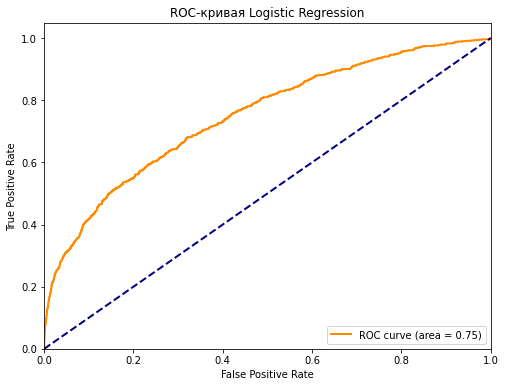

CPU times: total: 2min 47s
Wall time: 2min 55s


In [62]:
%%time
y_scores = cross_val_predict(lr, X_train_lr, y_train, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

# строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### 4.4 Модель "DecisionTreeClassifier"

In [63]:
# признаки для логистической регрессии
X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

In [64]:
# закодируем категориальные признаки и масштабируем числовые 
#transformer_dt = make_column_transformer((StandardScaler(), num_features), 
                                         #(OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features),
                                         #remainder='passthrough', verbose_feature_names_out=False
                                        #)

In [65]:
# закодируем категориальные признаки и масштабируем числовые 
transformer_dt = make_column_transformer((StandardScaler(), num_features), 
                                         (OrdinalEncoder (handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False)

In [66]:
# создадим модель
model_dt = make_pipeline(transformer_dt, DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))

In [67]:
# определяем параметры для перебора в GridSearchCV
parametrs_dt = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__max_depth': [None, 5, 10],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10],
    'decisiontreeclassifier__min_samples_leaf': [1, 2, 5],
    'decisiontreeclassifier__max_features': ['auto', 'sqrt']
}

In [68]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
dt = GridSearchCV(model_dt, param_grid=parametrs_dt, cv=5, scoring='roc_auc')

# обучим на тренировочных данных
dt.fit(X_train_dt, y_train)

y_pred_train_dt = dt.predict(X_train_dt)
dt_accuracy = accuracy_score(y_train, y_pred_train_dt)

print('\033[1m' + 'Модель "DecisionTreeClassifier"' + '\033[0m')
print('\033[1m' + 'Лучший ROC-AUC:' + '\033[0m', dt.best_score_)
print('\033[1m' + 'Accuracy:' + '\033[0m', dt_accuracy)
print('=' * 40)
print("Лучшие параметры:", dt.best_params_)
print('=' * 40)

Модель "DecisionTreeClassifier"
Лучший ROC-AUC: 0.7632312101992509
Accuracy: 0.68099204846649
Лучшие параметры: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 5, 'decisiontreeclassifier__max_features': 'auto', 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
CPU times: total: 18.7 s
Wall time: 18.9 s


### 4.5 Модель "RandomForestClassifier"

In [69]:
# признаки для Регрессии случайного леса 
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [70]:
# закодируем категориальные признаки и масштабируем числовые
transformer_rf = make_column_transformer((StandardScaler(), num_features),
                                         (OrdinalEncoder (handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
                                         remainder = 'passthrough', verbose_feature_names_out=False)

In [71]:
# создадим модель
model_rf = make_pipeline(transformer_rf, RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))

In [72]:
# определяем параметры для RandomizedSearchCV
parametrs_rf = {
    'randomforestclassifier__n_estimators': range(50, 351, 50),
    'randomforestclassifier__max_depth': range(2, 50,2),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4, 5, 6)
               }

In [73]:
%%time
# обучим модель и найдем лучшие параметры
rf = RandomizedSearchCV(
    model_rf, 
    param_distributions=parametrs_rf, 
    scoring='roc_auc', 
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf.fit(X_train_rf, y_train)

y_pred_train_rf = rf.predict(X_train_rf)
rf_accuracy = accuracy_score(y_train, y_pred_train_rf)

print('\033[1m' + 'Модель "RandomForestClassifier"' + '\033[0m')
print('\033[1m' + 'Лучший ROC-AUC:' + '\033[0m', rf.best_score_)
print('\033[1m' + 'Accuracy:' + '\033[0m', rf_accuracy)
print('=' * 40)
print("Лучшие параметры:", rf.best_params_)
print('=' * 40)

Модель "RandomForestClassifier"
Лучший ROC-AUC: 0.8213103574815049
Accuracy: 0.9093146535403256
Лучшие параметры: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_depth': 46}
CPU times: total: 1.34 s
Wall time: 7.28 s


### 4.6 Модель "CatBoostClassifier"

In [74]:
# признаки для Регрессии КэтБуст
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

In [75]:
# создадим модель и передадим ей категориальные признаки
model_cb = CatBoostClassifier(random_state=RANDOM_STATE, 
                              verbose=False,
                              class_weights=[0.156325, 0.843675],
                              cat_features=['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']) 

In [76]:
# параметры для подбора
parameters_cb = [{'learning_rate':[0.1, 0.3, 0.5, 0.8],
               'depth':[4,6,8,10],
               'iterations':[30, 50, 100, 300],
               'verbose':[False]}]

In [77]:
%%time
# подберем лучшие параметры для модели CatBoostRegressor
cb = GridSearchCV(
    estimator=model_cb,
    param_grid = parameters_cb,
    cv = 2,
    scoring='roc_auc',
    n_jobs=-1
)

cb.fit(X_train_cb, y_train)

y_pred_train_cb = rf.predict(X_train_cb)
cb_accuracy = accuracy_score(y_train, y_pred_train_cb)

print('\033[1m' + 'Модель "CatBoostClassifier"' + '\033[0m')
print('\033[1m' + 'Лучший ROC-AUC:' + '\033[0m', cb.best_score_)
print('\033[1m' + 'Accuracy:' + '\033[0m', cb_accuracy)
print('=' * 40)
print("Лучшие параметры:", cb.best_params_)
print('=' * 40)

Модель "CatBoostClassifier"
Лучший ROC-AUC: 0.8775033580970348
Accuracy: 0.9093146535403256
Лучшие параметры: {'depth': 4, 'iterations': 300, 'learning_rate': 0.3, 'verbose': False}
CPU times: total: 17.5 s
Wall time: 2min 43s


### 4.7 Сравним ROC-AUC моделей на обучающей выборке

In [78]:
# таблица ROC-AUC моделей на обучающей выборке
index_result =['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'CatBoostClassifier']
data_result = {'ROC-AUC на обучающей выборке':[lr.best_score_, dt.best_score_, rf.best_score_, cb.best_score_],
              'Accuracy на обучающей выборке':[lr_accuracy, dt_accuracy, rf_accuracy, cb_accuracy]}

result = pd.DataFrame(data=data_result, index=index_result)
result

,ROC-AUC на обучающей выборке,Accuracy на обучающей выборке
LogisticRegression,0.749248,0.693109
DecisionTreeClassifier,0.763231,0.680992
RandomForestClassifier,0.821310,0.909315
CatBoostClassifier,0.877503,0.909315


### 4.8 Лучшая модель CatBoostClassifier

**1. Cоздадим и обучим модель с лучшими параметрами, передадим ей категориальные признаки**

In [79]:
%%time
best_model_cb = CatBoostClassifier(random_state=RANDOM_STATE,
                                   depth=4,
                                   iterations=300,
                                   learning_rate=0.3,
                                   verbose=False,
                                   class_weights=[0.156325, 0.843675],
                                   cat_features=['type', 'paperless_billing', 'payment_method', 'gender', 'partner',
       'dependents', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines'])
best_model_cb.fit(X_train_cb, y_train)

CPU times: total: 18.1 s
Wall time: 7.57 s


**2. Получим предсказания  лучшей модели CatBoostClassifier на тестовой выборке**

In [80]:
%%time
predict_test_cb = best_model_cb.predict(X_test_cb)

CPU times: total: 46.9 ms
Wall time: 16.8 ms


**3. Найдем значения AUC-ROC и Accuracy**

In [81]:
# найдем значения вероятностей классов для тестовой
probabilities_valid = best_model_cb.predict_proba(X_test_cb)

# выберем вероятности положительного класса ("1")
probabilities_one_valid = probabilities_valid[:, 1]

# посчитаем значение AUC-ROC на тестовой выборке и выведем его
auc_roc = roc_auc_score(y_test, probabilities_one_valid)
print('\033[1m'+ 'AUC-ROC модели CatBoostClassifier: '+ '\033[0m', auc_roc)

# посчитаем значение Accuracy
y_pred_cb = best_model_cb.predict(X_test_cb)
best_model_cb_accuracy = accuracy_score(y_test, y_pred_cb)
print('\033[1m' + 'Accuracy:' + '\033[0m', best_model_cb_accuracy)

AUC-ROC модели CatBoostClassifier:  0.9225058118194054
Accuracy: 0.8796138557637706


**4. Построим AUC-ROC - кривую для лучшей модели**

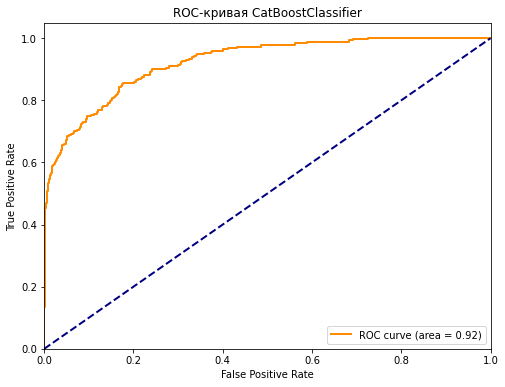

In [82]:
# предсказанных вероятностей класса 1
y_pred_proba = best_model_cb.predict_proba(X_test_cb)[:, 1]

# передаем на вход значения целевого признака и вероятности положительного класса
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# вычисление значения AUC
roc_auc = auc(fpr, tpr)

# строим ROC-кривую
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая CatBoostClassifier')
plt.legend(loc="lower right")
plt.show()

**5. Оценим важность признаков для лучшей модели CatBoostClassifier**

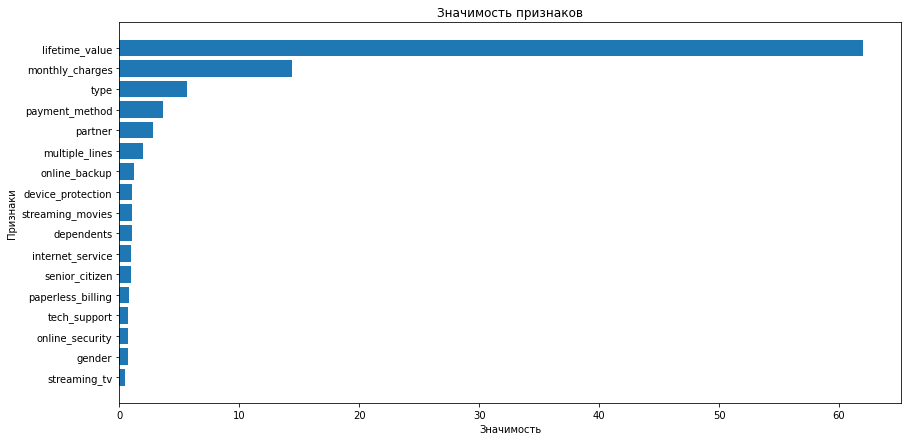

In [83]:
# получим признаки
importance = best_model_cb.feature_importances_
feature_names = X_train_cb.columns

# сортируем
sorting = np.argsort(importance)[0::]
sorting_importance = importance[sorting]
sorting_feature_names = feature_names[sorting]

# визуализируем
plt.figure(figsize=(14, 7))
plt.barh(range(len(importance)), sorting_importance)
plt.yticks(range(len(importance)), sorting_feature_names)
plt.xlabel('Значимость')
plt.ylabel('Признаки')
plt.title('Значимость признаков')
plt.show()

## 5. Вывод

Задача проекта построить модель, которая на основе предоставленных данных сделает прогноз: уйдёт клиент от оператора в ближайшее время или нет.

Основной метрикой по которому оценивается качество предсказания является ROC-AUC с целевым показетелем >= 0.85.

Заказчиком были предоставленны данные о клиентах содержащиеся в 4-х таблицах.

На этапе подготовки и исследования данных было:
* произведено объединение таблиц по ключу 
* удаленные не нужные признаки
* заполненые пропуски
* создан новый признак
* выделен целевой признак
* данные приведены в соответсвующие форматы

Для поиска лучше модели были исследованы:
- LogisticRegression 
- DecisionTreeClassifier 
- RandomForestClassifier 
- CatBoostClassifier

На обучающей выборке лучший результат получен у модели CatBoostClassifier с параметрами: {'depth': 4, 'iterations': 300, 'learning_rate': 0.3, 'verbose': False}
- ROC-AUC: 0.87
- Accuracy: 0.90

На этой модели CatBoostClassifier проведено финальное исследование на тестовой выборке:
- ROC-AUC: 0.92
- Accuracy: 0.87

Достигнут уровень целового показателя ROC-AUC >= 0.85

Три самых важных признаков для модели являются:
* lifetime_value - срок взаимодействия клиента с оператором
* monthly_charges - размер ежемесячного платежа
* type - тип оплаты: ежемесячный, годовой и т.д.

Для дальнейшей работы по выявлению клиентов потенциально готовых закрыть контракт рекомендовано использовать модель CatBoostClassifier.

<h1> III часть: ОТЧЕТ </h1>

## 1. Введение

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. Была поставлена задача - построить модель, которая на основе предоставленных данных сделает прогноз: уйдёт клиент от оператора в ближайшее время или нет.

## 2. Методология

Этот проект предполагал решить задачу классификации и по условиям заказчика качество предсказания оценивалось метрикой `ROC-AUC`. Метрика `ROC-AUC` помогает нам сделать оценкуоценить, насколько хорошо модель способна различать классы. Чем выше значение `ROC-AUC`, тем лучше модель. Целевой показатель метрики `ROC-AUC` был установлен заказчиком **>= 0.85**.

Перед выполнением проекта был составлен план работы, который сотоял из:
1. Первичной оценки данных
2. Предобработки данных
3. Исследовательского анализа
4. Подготовки учебных и тестовых датасетов
5. Обучения моделей с подбором гиперпараметров и выбора лучшей модели классификации
В ходе работы над проектом в целом удалось соблюсти план работ. 

Для обучения были выбраны 4 модели-классификатора:
* `LogisticRegression`
* `DecisionTreeClassifier`
* `RandomForestClassifier`
* `CatBoostClassifier`

Данные были предоставлены в виде 4-х таблиц с различной информацией о поведении клиентов: дата подключения, суммы и способы оплат, использование дополнительных услуг, персональная информация и данные о продолжении сотрудничества или его окончании. Все таблицы содержали единый ID клиента. Для дальнейшей работы таблицы были соединины в один датасет по ключу - ID клиента, а данные были преведены к соответствующим форматам, обработаны пропуски.

На этапе предобработки был создан целевой бинарный признак, подтвержающий факт ухода клиента. Кроме этого, создан дополнительный признак с данными о сроке взаимодействия клиента с компанией. Лишние признаки, которые не потребовались бы для дальнейшего обучения были удалены: ID клиента, дата подключения, дата ухода. 

В ходе исследовательского анализа были выявлены мультиколлениарные признаки, проведена оценка чиловых признаков на предмет аномальных значений и выбросов, рассмотрены и описаны категориальные признаки. Для исключения влияния мультиколлениарности на обучение моделей - признак был удален. В ходе анализа также выяснилось, что целевой признак не сбалансирован.

Общий размер датасета после после всех проведенных манипуляций составил 7043 строки и 17 признаков, таким образом нам удалость сохранить данные всех клиентов. Поскольку датасет имеет не очень большой размер, то выделение валидацонной выборки было нецелесообразно и лучший вариант использовать кросс-валидацию. Был применен `GridSearchCV` - для всех моделей и `RandomizedSearchCV` - только для `RandomForestClassifier` для увеличения скорости подбора. 

## 3. Признаки и подготовка

Список признаков, которые использовались для обучения для обучения моделей: 
- `type` - тип оплаты: ежемесячный, годовой и т.д.
- `paperless_billing` - безналичный расчет
- `payment_method` - способ оплаты
- `gender` - пол
- `partner` – наличие супруга(и)
- `dependents`– наличие иждивенцев
- `internet_service` - интернет-сервисы 
- `online_security` - блокировка небезопасных сайтов 
- `online_backup`- резервное копирование
- `device_protection` - антивирус 
- `tech_support` - выделенная линия технической поддержки
- `streaming_tv` - стриминговое телевидение
- `streaming_movies` - каталог фильмов
- `multiple_lines` – наличие возможности ведения параллельных линий во время звонка
- `monthly_charges` – ежемесячные траты на услуги
- `senior_citizen` – наличие пенсионного статуса по возрасту
- `lifetime_value` - общий срок пользования услугами компании

Целевой признак - `exited` показывал, ушел клиент - 1 или остался с оператором - 0. 

Перед обучением данные были разделены на обучающую выборку и тестовую в соотношении 75:25. При разделении и далее использовался параметр random_state = 50623.

Затем категориальные данные прошли кодировку при помощи `OneHotEncoder` для модели ``LogisticRegression`, а для моделей `DecisionTreeClassifier` и `RandomForestClassifier` использовался `OrdinalEncoder`. 
Для модели `CatBoostClassifier` подавались исходные категориальные признаки, так как модель умеет самостоятельно кодировать такие признаки. Числовые признаки стандартизировали с помощью `StandardScaler`. На этом этапе для каждой из моделей был собран `Pipeline`.
Трудностей при обработке признаков и создании `Pipeline` для моделей в ходе испольнения проекта не возникло.

## 4. Модели

Для кождой из 4-х моделей-классификаторов методом кросс-валидации был проведен подбор гиперпараметров и получено лучшее значение метрики ROC-AUC. 
В качестве дополнительной метрики использовалсь метрика Accuracy, которая позволяет оценить, насколько точно модель классифицирует данные.
Итоговые данные занесены в таблицу.
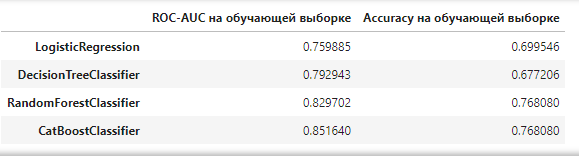

Лучший результат получен у модели CatBoostClassifier: 
- `ROC-AUC`: 0.85 (достигнут целевой показатель)
- `Accuracy`: 0.84

Гиперпараметры лучшей модели: 

**CatBoostClassifier (random_state=RANDOM_STATE, depth=6, iterations=100, learning_rate=0.5, verbose=False, class_weights=[0.156325, 0.843675], cat_features=cat_features)**
                                   
Эта модель была выбрана для финального тестирования. 
Результаты предсказания модели на тестовой выборке:
- `ROC-AUC`: 0.87 (целевой показатель выше целевого)
- `Accuracy`: 0.84      

Дополнительно были оценена степень значимости признаков для обучения модели. 
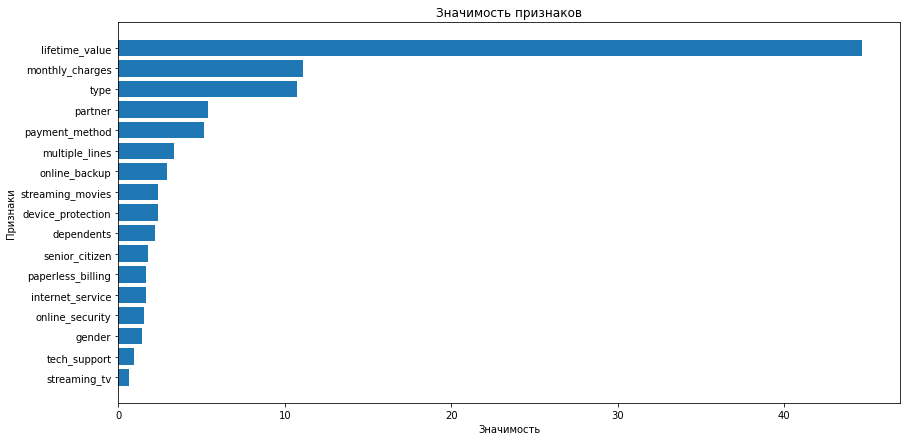

В дальнейшем, признаки с наименьшей значимостью могут не использоваться для обучения модели.

## 5. Выводы

В ходе выполнения проекта была решена задача классификации - предсказать уйдет ли в дальнейшем клиент или останется. Для решения этой задачи использовались модели-классификаторы:
* `LogisticRegression`
* `DecisionTreeClassifier`
* `RandomForestClassifier`
* `CatBoostClassifier`
,которые были обучены на данных предоставленных заказчиком. 

Данные были дополнительно исследованы и подготовленны должным образом для каждой модели. В процессе обучения методом кросс-валидации найдены лучшая модель и её гиперпараметры - `CatBoostClassifier (random_state=RANDOM_STATE, depth=6, iterations=100, learning_rate=0.5, verbose=False, class_weights=[0.156325, 0.843675], cat_features=cat_features)`. Результаты модели на тестовой выборке: `ROC-AUC = 0.87`, что лучше необходимого заказчику показателя. 

Решение данной задачи позволит заказчику удерживать клиентов с низкой лояльностью, предлагая им дополнительные бонусы, что улучшит бизнес показатели компании-оператора связи.